# Advanced Lane Finding



### compute the camera calibration matrix and distortion coefficents

computing camera calibration is done in the following steps:
* prepare object point matrix
* convert image to grayscale
* finding chessboard corners
* append detected corners for each image
* [optional] draw corners on the image, for checking for detection
* calibrate camera with detected corners from all images

All these above steps is done in function `calibrate` in `camera.py`, which is used in the code bellow as `camera.calibrate`. 

Calibration can also be executed with `camera.py` as a standalone, from console as this example:
```
$ python camera.py --ipath camera_cal --numx 9 --numy 6 -o camera_calibration_data.p
```  
Add `--opath output_images` as parameter to above command for producing result from corner detection for sanity check purposes. For complete help discription of use `-h` or `--help` as a parameter to `camera.py`.

#### prepating object point matrix

Operation for creating object point matrix:
```
    objpnt = np.zeros((ny*nx, 3), np.float32)
    objpnt[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
```
Here `nx` and `ny` correspons number of corners in x and y direction on the chessboard calibration images, given as paramter `--numx` and `--numy` in the command line tool. Look at the number of detected points in x and y direction in the `example of corner finding result` image bellow.

#### convert image to grayscale

This is done by `cv2.cvtColor` function as follows:
```
    # convert image to grayscale 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
```


```
def calibrate(path, nx, ny, save=False, out_path = 'output_images'):
    objpoints = []
    imgpoints = []

    objpnt = np.zeros((ny*nx, 3), np.float32)
    objpnt[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # get all files in directory with path included 
    camera_cal_files = tls.files_in_dir(path, True)

    for file in camera_cal_files:
        # read image from file
        image = cv2.imread(file)

        # convert image to grayscale 
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        #find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objpnt)
            
            if save == True:
                cv2.drawChessboardCorners(image, (nx,ny), corners, ret)
                head, tail = os.path.split(file)
                tls.save_image_as(image, 'corners_{}'.format(tail), out_path) 

    # returns ret, mtx, dist, rvecs, tvecs
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
```

The camera.py can also be used standalone for calculating and storing the result of camera calibration, as follows:
```
$ python camera.py --ipath camera_cal --numx 9 --numy 6 -o camera_calibration_data.p
```  

#### Bellow is an example of the results of the camera calibration corner findings: 

<table style="width:100%">
  <tr>
      <td colspan="2"><center><H3>example of corner finding result</H3></center></td>
  </tr>
  <tr>
    <td><img src="output_images/corners_calibration2.jpg" width="90%" height="90%"/></td>
    <td><img src="output_images/corners_calibration3.jpg" width="90%" height="90%"/></td>
  </tr>
  <tr>
    <td><center>calibration2</center></td>
    <td><center>calibration3</center></td>
  </tr>
</table> 



In [1]:
import camera
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# computes the calibration of images in 'camera_cal', see camera.py for implementation
ret,mtx,dist,rvecs,tvecs = camera.calibrate('camera_cal', 9, 6, save=True)

# store camera calibration data to file - for later use
camera.store('camera_calibration_data.p', ret, mtx, dist, rvecs, tvecs)

# plot corner finding images, 'save=True'
corner_findings_files = glob.glob('output_images/corners_*.jpg')

# plot two of the corner finding result images 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

img01 = mpimg.imread(corner_findings_files[0])
ax1.set_title(corner_findings_files[0])
ax1.imshow(img01)

img02 = mpimg.imread(corner_findings_files[1])
ax2.set_title(corner_findings_files[1])
ax2.imshow(img02)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle, os

import tools as tls
import camera


data = camera.load('camera_calibration_data.p')

mtx = data["mtx"]
dist = data["dist"]

test_files = tls.files_in_dir('test_images', True)

for file in test_files:
    # read next file in list
    #image = cv2.imread(file)
    image = mpimg.imread(file)
    
    # undistorte the image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # take the diff between original image and undist image
    diff = image - undist
    
    # save undistorted image to output_images
    head, tail = os.path.split(file)
    undist = cv2.cvtColor(undist, cv2.COLOR_RGB2BGR)
    tls.save_image_as(undist, 'undist_{}'.format(tail), 'output_images')
    
    # save diff of orginal and undistorted image
    diff = cv2.cvtColor(diff, cv2.COLOR_RGB2BGR)
    tls.save_image_as(diff, 'undist_diff_{}'.format(tail), 'output_images')

In [ ]:
<figure>
    <img src="output_images/corners_calibration2.jpg" width="50%" height="50%"/>
    <figcaption><center>example of corner finding result</center></figcaption>
</figure>


<table style="width:100%">
  <tr>
      <td colspan="2"><center><H3>example of corner finding result</H3></center></td>
  </tr>
  <tr>
    <td><img src="output_images/corners_calibration2.jpg" width="90%" height="90%"/></td>
    <td><img src="output_images/corners_calibration3.jpg" width="90%" height="90%"/></td>
  </tr>
  <tr>
    <td><center>calibration2</center></td>
    <td><center>calibration3</center></td>
  </tr>
</table> 


In [ ]:
import cv2, camera
import tools as tls
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from pipeline import lane_detector 

out = 'output_images'

#test_files = tls.files_in_dir('harder_challenge_video', True)
#out = tls.path_join(out, 'harder')

#test_files = tls.files_in_dir('challenge_video', True)
#out = tls.path_join(out, 'challenge')

test_files = tls.files_in_dir('project_video', True)
out = tls.path_join(out, 'project')

#test_files = tls.files_in_dir('test_images', True)
#out = tls.path_join(out, 'test')
       
detect = lane_detector('camera_calibration_data.p')        

detect.out = out

r_thresh = (180, 200)
g_thresh = ( 30, 120)
b_thresh = (190, 240)

detect.r_thresh = r_thresh
detect.g_thresh = g_thresh
detect.b_thresh = b_thresh

detect.debug_binary = True
detect.debug_warped = True
detect.debug_histogram = True

for file in test_files:
    file_only = tls.filename_from_path(file)
    base, ext = tls.filename_split(file_only)
    
    detect.base = base
    
    image = cv2.imread(file)
    
    result = detect.process(image)
    
    tls.save_image_as(result, '{}_result{}'.format(base,ext), tls.path_join(out, 'result'))
    

In [42]:
# analyse test_images
import video

#path1 = 'test_images'
path1 = 'output_images/test/binary'
path2 = 'output_images/test/warped'
filename = 'output_video/test-analyse.mp4'

video.image2video(filename, path1, path2)

In [3]:
# analyse project_video
import video

#path1 = 'test_images'
path1 = 'output_images/project/binary'
path2 = 'output_images/project/result'
filename = 'output_video/project-analyse'

video.image2video(filename, path1, path2)

In [21]:
import numpy as np

def generate_data():
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    return ploty, left_fit, right_fit
    
def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

1625.0601831657204 1976.2967307714334


In [22]:
import numpy as np

def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_cr, right_fit_cr
    
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

533.7525889210938 m 648.157485143441 m


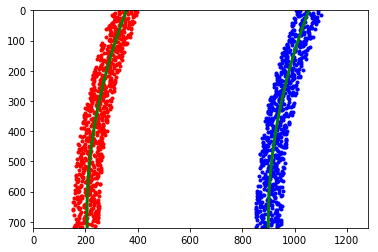

In [10]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
w,h = image.shape[1::-1]
    
    # undistorte the image
    #undist = cv2.undistort(image, mtx, dist, None, mtx)
    undist = detect.undistort(image)

    # apply gradients and threshold
    color = detect.gradients(undist)
    tls.save_image_as(color, '{}_binary{}'.format(base,ext), tls.path_join(out, 'binary'))
    
    binary = color[:,:,0] + color[:,:,1] + color[:,:,2]
    binary = channel_threshold(binary,(1,255))
    
    # src and dst points
    src = np.float32([[50,h],[w-50,h],[720,h//2+80],[570,h//2+80]])
    dst = np.float32([[200,h],[w-200,h],[w-200,0],[200,0]])
    
    lines = np.copy(undist)
    cv2.line(lines, tuple(src[0]), tuple(src[1]), (255,0,0), 5)
    cv2.line(lines, tuple(src[1]), tuple(src[2]), (255,0,0), 5)
    cv2.line(lines, tuple(src[2]), tuple(src[3]), (255,0,0), 5)
    cv2.line(lines, tuple(src[3]), tuple(src[0]), (255,0,0), 5)
    cv2.line(lines, tuple(dst[0]), tuple(dst[1]), (0,255,0), 5)
    cv2.line(lines, tuple(dst[1]), tuple(dst[2]), (0,255,0), 5)
    cv2.line(lines, tuple(dst[2]), tuple(dst[3]), (0,255,0), 5)
    cv2.line(lines, tuple(dst[3]), tuple(dst[0]), (0,255,0), 5)
    tls.save_image_as(lines, '{}_lines{}'.format(base,ext), tls.path_join(out, 'lines'))
    
    warped = detect.warp(binary, src, dst)
    tls.save_image_as(warped*255, '{}_warped{}'.format(base,ext), tls.path_join(out, 'warped'))

    # Take a histogram of the bottom half of the image
    histogram = np.sum((warped[warped.shape[0]//2:,:]), axis=0)
    
    # calculate the midpoint in the histogram
    midpoint = np.int(histogram.shape[0]//2)
    
    # Find the peak of the left and right halves of the histogram 
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    

    # find lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped, leftx_base, rightx_base)
    
    # Fit a second order polynomial to each 
    left_fit =  np.polyfit(lefty,  leftx, 2) 
    right_fit = np.polyfit(righty, rightx, 2) 
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # draw green lines between the two curves
    for i in range(left_fitx.shape[0]):
        x1 = left_fitx[i].astype(np.int)
        x2 = right_fitx[i].astype(np.int)
        cv2.line(out_img, (x1,i),(x2,i), (0,255,0), 5)

    tls.save_image_as(out_img, '{}_out_img{}'.format(base,ext), tls.path_join(out, 'fit'))

    # calculate curvature
    left_curverad_pix, right_curverad_pix = measure_curvature_pixels(ploty, left_fitx, right_fitx)
    #print('curvature_pix', left_curverad, right_curverad)
    
    # calculate curvature
    left_curverad_real, right_curverad_real = measure_curvature_real(ploty, left_fitx, right_fitx)
    #print('curvature_real', left_curverad, right_curverad)
    
    
    # get the inverse matrix and inverse transform
    unwarped, Mi = warp(out_img, dst,src)
    
    # mix undist image and the unwarped 'detection' image
    result = cv2.addWeighted(undist, 0.9, unwarped, 0.2, 0)
    
    # format text to be added to image
    curvatureText = 'curvature= {:.0f} m {:.0f} m'.format(left_curverad_pix, 
                                                          right_curverad_pix)
    left = leftx_base - midpoint
    right = rightx_base - midpoint
    diff = right + left
    
    side = 'middel of'
    if diff > 0:
        side = 'left of'
    elif diff < 0:
        side = 'right of'
    
    # absolute difference
    adiff = np.abs(diff)
    aleft = np.abs(left)
    aright = np.abs(right)
    
    # vehicle lane 3.7m us highway - https://en.wikipedia.org/wiki/Lane
    lane_size = 3.7
    value = adiff * (lane_size / (aleft + aright))
    
    positionTxt = '{:.02f} m {} lane center ({}, {}, {}, {})'.format(value, side, midpoint, left,right, adiff)

    
    # output curvature and lane position as text
    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(result, curvatureText,(50, 50), font, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result, positionTxt,  (50,100), font, 2,(255,255,255),2,cv2.LINE_AA)
    
    tls.save_image_as(result, '{}_result{}'.format(base,ext), tls.path_join(out, 'result'))